# Week 4 - Probabilistic Programming with Pyro

## Part 1 - Introduction to Pyro

Hello again. We've finally arrived to Pyro - a platform for probabilistic programming!

The main purpose of this notebook is to introduce Pyro. Afterwards, **it is highly recommended that you complement the information in this notebook with the following 2 official introduction tutorials from the Pyro developers**:
- https://pyro.ai/examples/intro_part_i.html
- https://pyro.ai/examples/intro_part_ii.html

...the usual imports...

well, notice the new packages!!

In [1]:
# If Pyro is not installed in your Jupyter environment, you can install it using the following command. 
# Note: you will probably also need to restart you runtime.
!pip install pyro-ppl

Error processing line 1 of /anaconda3/lib/python3.7/site-packages/protobuf-3.10.0-py3.7-nspkg.pth:

  Traceback (most recent call last):
    File "/anaconda3/lib/python3.7/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 580, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import pyro

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# usually have to run this twice to take effect
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

### 1.1. Pyro's distribution library

Pyro's distribution library ```pyro.distributions``` is built on top of PyTorch's distributions ```torch.distributions``` in order to make use of PyTorch's fast tensor math and autograd (automatic differentiation) capabilities during inference. 

You can define a new distribution as follows:

In [4]:
mu = 0.
sigma = 1.
my_dist = pyro.distributions.Normal(loc=mu, scale=sigma)

Using the ```my_dist``` object that we have just instantiated, we can draw samples from the corresponding distribution:

In [5]:
x = my_dist.sample()
print("x:", x)

x: tensor(1.5505)


Notice that the function returns a PyTorch ```tensor``` object. Fortunately, it is extremely easy to convert back and forward between Numpy vectors and matrices and PyTorch tensors. Check the some of the options below:

In [6]:
# from Python list to PyTorch tensor
x = [1,2,3]
x = torch.tensor(x)
print(x, type(x))

# from PyTorch tensor to Numpy ndarray
x = x.numpy()
print(x, type(x))

# from Numpy ndarray back to PyTorch tensor
x = torch.from_numpy(x)
print(x, type(x))

tensor([1, 2, 3]) <class 'torch.Tensor'>
[1 2 3] <class 'numpy.ndarray'>
tensor([1, 2, 3]) <class 'torch.Tensor'>




We can also draw multiple independent samples (in this case a 20x2 matrix of independent samples) using the following PyTorch-style syntax:

In [7]:
x = my_dist.sample(sample_shape=torch.Size([10,2]))
print("Shape of x:", x.shape)
print("x:", x)

Shape of x: torch.Size([10, 2])
x: tensor([[-1.4623, -0.2328],
        [-0.9080,  1.0756],
        [-0.0081, -1.8344],
        [-1.0278, -0.8618],
        [-0.2216, -0.8939],
        [ 0.3793,  0.3091],
        [ 0.6985, -1.1132],
        [ 0.2051, -0.3552],
        [-0.1437, -0.2505],
        [ 0.4429, -0.4368]])


Given a collection of samples ```x```, we can also compute their log-probability under the distribution ```my_dist``` as follows:

In [8]:
print("Loglikelihood of samples in x:\n", my_dist.log_prob(x))

Loglikelihood of samples in x:
 tensor([[-1.9881, -0.9460],
        [-1.3312, -1.4974],
        [-0.9190, -2.6015],
        [-1.4471, -1.2903],
        [-0.9435, -1.3185],
        [-0.9909, -0.9667],
        [-1.1629, -1.5386],
        [-0.9400, -0.9820],
        [-0.9293, -0.9503],
        [-1.0170, -1.0143]])


Notice that, because the samples are assumed to be independent, the code above returns a log probability score for each sample. However, we can compute the log probability of the entire set of samples easily:

In [9]:
print("Loglikelihood of entire dataset x:", my_dist.log_prob(x).sum())

Loglikelihood of entire dataset x: tensor(-24.7746)


### 1.2. Tensor shapes and batch semantics in Pyro 

Like Numpy ndarrays, PyTorch tensors have a single ```.shape``` attribute, but Pyro distributions have two shape attributions with special meaning: ```.batch_shape``` and ```.event_shape```. Can you check the ```.batch_shape``` and ```.event_shape``` of ```my_dist```?

In [10]:
my_dist = pyro.distributions.Normal(torch.zeros(10, 2), torch.ones(10, 2))
print("batch_shape:", my_dist.batch_shape)
print("event_shape:", my_dist.event_shape)

batch_shape: torch.Size([10, 2])
event_shape: torch.Size([])


Let's now take a sample from ```my_dist```:

In [11]:
x = my_dist.sample()

Now check the shape of the sample that you just obtained. Does it make sense? Notice how that is equal to the sum of the ```batch_shape``` and the ```event_shape```. Why?

In [12]:
print(x.shape)
assert x.shape == my_dist.batch_shape + my_dist.event_shape

torch.Size([10, 2])


Indices over ```.batch_shape``` denote conditionally independent random variables, whereas indices over ```.event_shape``` denote dependent random variables (ie one draw from a distribution). Because the dependent random variables define probability together, the ```.log_prob()``` method only produces a single number for each event of shape .event_shape. Thus the total shape of ```.log_prob()``` is ```.batch_shape```.

Let's consider a concrete example:

In [27]:
my_dist = pyro.distributions.Normal(torch.zeros(10, 2), torch.ones(10, 2))
print("my_dist shape:", my_dist.shape())
print("my_dist batch_shape:", my_dist.batch_shape)
print("my_dist event_shape:", my_dist.event_shape)

my_dist shape: torch.Size([10, 2])
my_dist batch_shape: torch.Size([10, 2])
my_dist event_shape: torch.Size([])


This indicates that a sample from ```my_dist``` will correspond to 10x2 independent draws. Therefore, evaluating ```.log_prob()``` will return 10x2 log probability values:

In [28]:
x = my_dist.sample()
print("shape of sample x:", x.shape)
print("shape of log prob of x:", my_dist.log_prob(x).shape)

shape of sample x: torch.Size([10, 2])
shape of log prob of x: torch.Size([10, 2])


In Pyro, we can treat a univariate distribution as multivariate by calling the ```.to_event(n)``` method where ```n``` is the number of batch dimensions (from the right) to declare as dependent. Try taking the distribution ```my_dist``` defined above, and declaring the right-most batch dimension as dependent using ```.to_event(1)```, and then check the ```batch_shape``` and the ```event_shape```. 

In [24]:
my_multivariate_dist = my_dist.to_event(1)
print("my_multivariate_dist shape:", my_multivariate_dist.shape())
print("my_multivariate_dist batch_shape:", my_multivariate_dist.batch_shape)
print("my_multivariate_dist event_shape:", my_multivariate_dist.event_shape)

my_multivariate_dist shape: torch.Size([10, 2])
my_multivariate_dist batch_shape: torch.Size([10])
my_multivariate_dist event_shape: torch.Size([2])


Compare these shapes with the ones from ```my_dist``` above. Does it make sense? 

If we now draw a sample from ```my_multivariate_dist```, what do you expect its shape to be? What about the log probability? Let's have a look:

In [25]:
x = my_multivariate_dist.sample()
print("shape of sample x:", x.shape)
print("shape of log prob of x:", my_multivariate_dist.log_prob(x).shape)

shape of sample x: torch.Size([10, 2])
shape of log prob of x: torch.Size([10])


Notice that the shape of ```x``` is still the same, but there is no assumption of conditional independence over the last dimension (of size 2). This means that ```x``` now contains a batch of 10 samples of a multivariate distribution with event size 2. Therefore, when we call ```.log_prob()```, each of the 10 samples in the batch will be scored, and the results is a vector of 10 log probabilities (one for each of the 10 events in the batch).

For more details about tensor shapes in Pyro read this: https://pyro.ai/examples/tensor_shapes.html

### 1.3. The pyro.sample primitive

The ```pyro.distributions``` library provides a way of specifying distributions from which we can efficiently draw samples and compute log probabilities. However, the distributions and corresponding samples that we defined above are detached from any meaning that could be exploited (e.g. by an inference engine) in the context of a large probabilistic model. In order to get a more meaningful definition we will make use of the ```pyro.sample``` primitive:

In [ ]:
my_dist = pyro.distributions.Normal(0., 1.)
x = pyro.sample("my_sample", my_dist)
print(x)

tensor(-1.4073)


Note that, like the sample statement from earlier, the ```pyro.sample``` primitive also returns a sample from the distribution. However, crucially, this sample is **named**. Pyro’s backend uses these names to uniquely identify sample statements when they are part of a larger model, and change their behavior at runtime depending on how the enclosing model uses them. As we will see, this is how Pyro can implement the various manipulations that underlie inference algorithms.

### 1.4. Defining models: Pyro's stochastic functions

All probabilistic programs are built up by composing primitive stochastic functions and deterministic computation. Using the primitives described above, we can then start building more complex stochastic functions. In Pyro, a probabilistic model is specified as a Python function that makes use of such stochastic primitives together with deterministic computation. For example, we can define the following simple model:

In [ ]:
def my_model(x):
    beta = pyro.sample("beta", pyro.distributions.Normal(0., 1.))
    y = torch.zeros(len(x))
    for i in pyro.plate("data", len(x)):
        y[i] = pyro.sample("y_%d"%i, pyro.distributions.Normal(beta*x[i], 1.))
    return y

Notice that the model function can also take external variables as input (in this case ```x```). 

Also, notice that we have introduced another extremely important Pyro primitive: ```pyro.plate```. This primitive serves to instruct Pyro that the observations are conditionally indepedent given the latent random variables (in this case ```beta```). We see that ```pyro.plate``` is very similar to Python's ```range()``` with one main difference: each invocation of plate requires the user to provide a unique name. The second argument is an integer just like for ```range()```. From a PGM perspective, there is an obvious connection between this plate primitive and the use of plates to denote repetition in PGMs. 

There is also a vectorized version of ```pyro.plate```, which enables large speed-ups compared to the sequential version above. Here is the equivalent vectorized version of the model definition above:

In [ ]:
def my_model(x):
    beta = pyro.sample("beta", pyro.distributions.Normal(0., 1.))
    with pyro.plate("data", len(x)):
        y = pyro.sample("y", pyro.distributions.Normal(beta*x, 1.))
    return y

Note that, with the vectorized version, we can simply write ```beta*x``` rather than ```beta*x[i]```.

Given a model definition as a stochastic function like the one above, we can use it to sample observations according to the model - i.e. perform *ancestral sampling*:

In [ ]:
input_x = torch.tensor([0,1,2,3,4,5,6,7,8,9])
sampled_y = my_model(input_x)
print(sampled_y)

tensor([ 0.5180, -1.4353, -2.0281, -0.2185, -2.1831, -2.9126, -4.9738, -2.4215,
        -6.1539, -6.8810])


Let's visualize the data that we generated:

Text(0, 0.5, 'sampled_y')

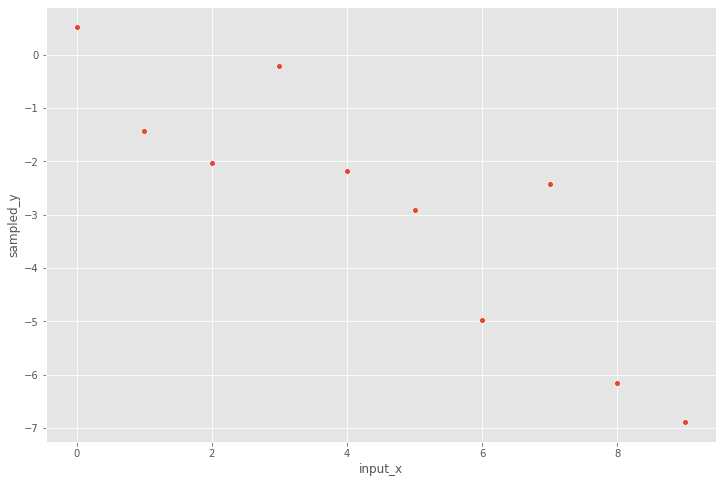

In [ ]:
sns.scatterplot(x=input_x, y=sampled_y)
plt.xlabel("input_x")
plt.ylabel("sampled_y")

### 1.5. Inference in Pyro

So far, the model definition from above (```my_model```) only allows us to draw samples from the model by following its generative process. In order to do the reverse procedure, i.e. *inference*, we need to be able to condition the model according to some real observations ```y_obs```. This can be easily done by modifying the model definition in order to take ```y_obs``` as input and using it to condition the corresponding ```pyro.sample``` statement:

In [ ]:
def my_model(x, y_obs):
    beta = pyro.sample("beta", pyro.distributions.Normal(0., 1.))
    with pyro.plate("data", len(y_obs)):
        y = pyro.sample("y", pyro.distributions.Normal(beta*x, 1.), obs=y_obs)
    return y

Given the model definition above, we can still generate samples from the model by passing ```y_obs=None``` as the argument. However, most importantly, we can now pass the model some actual observations ```y_obs``` and ask Pyro to perform Bayesian inference on the remaining random variables (in this case ```beta```). In order to do so, Pyro supports 2 main types of inference: MCMC (namely a technique called Hamiltonian Monte Carlo, or "HMC" for short) and Variational Inference (or "VI" for short). You will learn more about these later on in the course.

Let's see how to use HMC (in particular something called the "No-U-Turn Sampler" or "NUTS") to perform inference on the random variable ```beta``` using Pyro:

In [ ]:
from pyro.infer import MCMC, NUTS

y_obs = torch.tensor([-1, 1, 3, 4, 5, 7, 7, 8, 9, 10]) # Suppose this was the vector of observed y's

# Run inference in Pyro
nuts_kernel = NUTS(my_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(input_x, y_obs)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [00:08, 184.55it/s, step size=9.85e-01, acc. prob=0.935]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      1.17      0.06      1.18      1.09      1.27    386.97      1.00

Number of divergences: 0


Easy, right? :-)

We can also directly access the samples drawn from the posterior distribution of the random variable ```beta```using:

In [ ]:
posterior_samples = mcmc.get_samples()

The code above returns the samples from the posterior as a Python dictionary that uses the names of the variables that we defined in the ```pyro.sample``` statements as dictionary keys:

In [ ]:
print(posterior_samples.keys())

dict_keys(['beta'])


Lastly, let's use the posterior samples that obtained in order to approximate the density function of the posterior distribution of ```beta```:

torch.Size([1000])


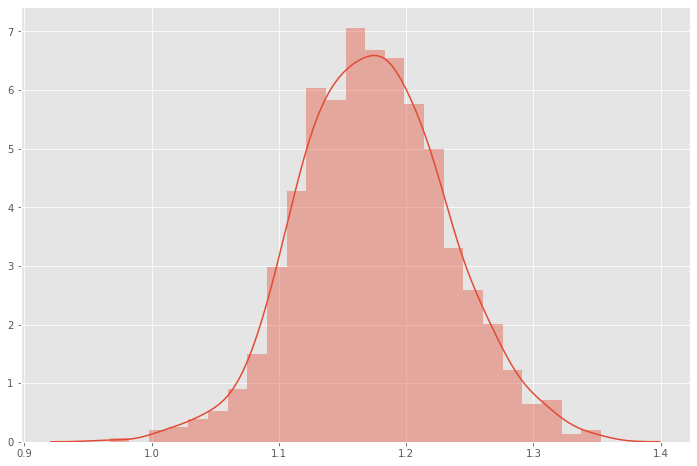

In [ ]:
print(posterior_samples['beta'].shape)

sns.histplot(posterior_samples['beta'], kde=True)
plt.show()

Notice that we had to convert the PyTorch tensor to a Numpy array using the ```.numpy()``` method in order for this to be possible.

## 2 Your first Pyro model

### 2.1 The cyclist problem

Let's do the cyclist problem from the lecture slides: We have a dataset of observations (travel times of bicycle trips), and we want to estimate its distribution, assuming it follows a Gaussian curve of some form. 

We can code this model in Pyro as follows:

In [ ]:
def cyclist_model(tt):
    at = pyro.sample("at", pyro.distributions.Normal(12, 10))
    tu = pyro.sample("tu", pyro.distributions.HalfCauchy(10))
    with pyro.plate("data", len(tt)):
        pyro.sample("tt", pyro.distributions.Normal(at, tu), obs=tt)

Check that everything makes sense, and don't hesitate to ask for clarifications!

As a curiosity, let's make the parallel with the corresponding STAN implementation of the equivalent model. Here is what it looks like in STAN. Try to identify the differences :-)

In [ ]:
cyclist_STAN="""
data {
    int<lower=0> N; // number of samples
    vector[N] tt;   // observed travel times
}
parameters {
    real at;          // average travel time
    real<lower=0> tu; // traffic uncertainty
}
model {
    at ~ normal(12, 10);
    tu ~ cauchy(0, 10);
    tt ~ normal(at, tu);
}
"""

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ccb3819b279763841816de16b66e504d NOW.


It is always good to have an intuitive notion of the prior forms (e.g. are they "too" informative, maybe? Or too wide?)

Can you plot the priors for _at_ and _tu_?

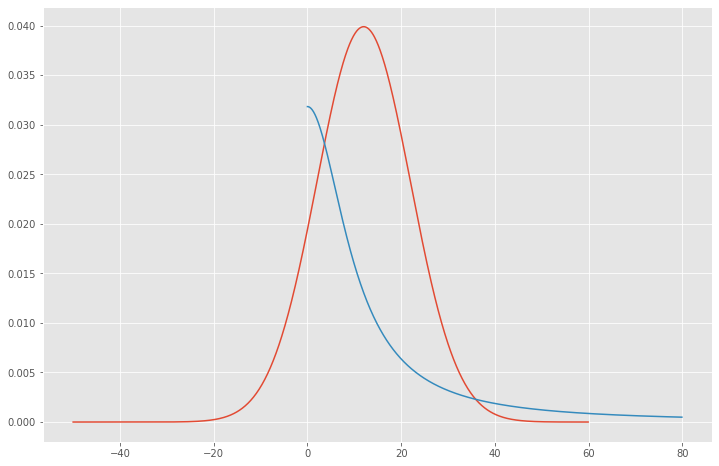

In [ ]:
from scipy.stats import cauchy, norm

x1=np.arange(-50, 60, 0.1)
x2=np.arange(0, 80, 0.1)

y1=norm.pdf(x1, 12, 10)
y2=cauchy.pdf(x2, 0, 10)

sns.lineplot(x=x1, y=y1);
sns.lineplot(x=x2, y=y2);

Given what we know of the problem, do they make sense? 




Below is the Python code that runs inference on the Pyro model ```cyclist_model``` defined above according to some observed data ```tt_obs```. 

In [ ]:
tt_obs = torch.tensor([13,17,16,32,12,13,28,12,14,18,36,16,16,31])

# Run inference in Pyro
nuts_kernel = NUTS(cyclist_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(tt_obs)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [00:21, 71.35it/s, step size=8.53e-01, acc. prob=0.902]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        at     19.07      2.54     19.14     14.52     22.75    346.45      1.00
        tu      8.92      1.84      8.60      5.89     11.53    600.34      1.00

Number of divergences: 0


Try to **inspect** the samples obtained by MCMC from the posterior distribution, particularly do a histogram for the "at" and "tu" variables.

Check how many samples you have, and relate the number with the statistics that Pyro provides above:
- How many samples did it actually generate?
- How many is it using for the final statistics?
- How many chains is it using (and how many samples being used in the end by each chain?)
- Plot the histogram of the samples



1000


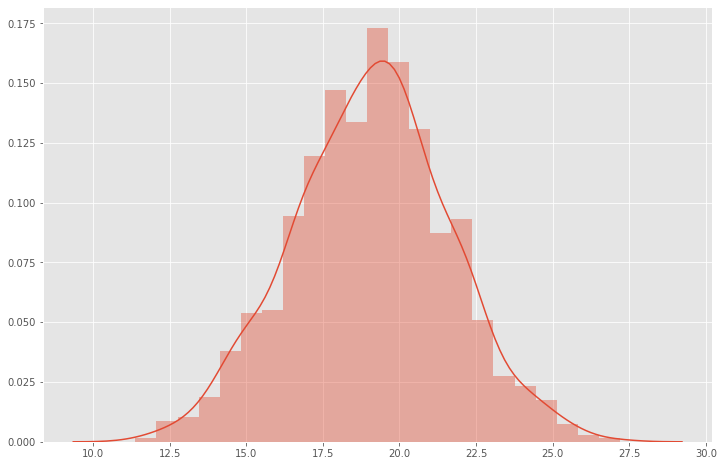

In [ ]:
# Get posterior samples
posterior_samples = mcmc.get_samples()

# Visualize histogram of samples
print(len(posterior_samples['at']))
sns.histplot(posterior_samples['at'], kde=True);

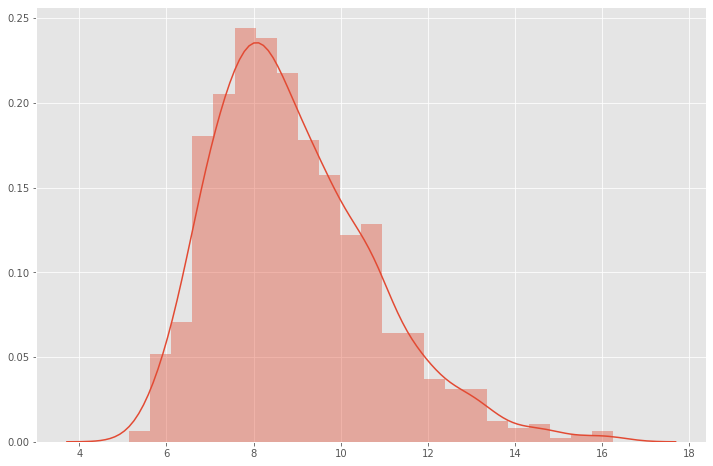

In [ ]:
sns.histplot(posterior_samples['tu'], kde=True);

To add to Pyro's summary output, we can also try to compute the mode of the posterior distribution using for example:

In [ ]:
from scipy import stats

print("\nAverage travel time:")
print("posterior mode=%.2f mean=%.2f std=%.2f" % (stats.mode(posterior_samples["at"].numpy().round(0))[0][0], 
                                                  posterior_samples['at'].mean(), posterior_samples['at'].std()))

print("\nTraffic uncertainty:")
print("posterior mode=%.2f mean=%.2f std=%.2f" % (stats.mode(posterior_samples["tu"].numpy().round(1))[0][0], 
                                                  posterior_samples['tu'].mean(), posterior_samples['tu'].std()))


Average travel time:
posterior mode=20.00 mean=19.07 std=2.54

Traffic uncertainty:
posterior mode=7.90 mean=8.92 std=1.84




Redefine the priors above and re-estimate the model (try only a couple of extreme values, just to see the effect)

### 2.2 Obtaining useful results from your model

Using the generated MCMC samples, you can find "cheap" answers to some interesting questions. For example, can you use the posterior samples to approximate the probability that the next trip takes less than 18 minutes?

In [ ]:
n_samples = len(posterior_samples['at'])
count = 0
for i in range(n_samples):
    tt_sample = np.random.normal(posterior_samples['at'][i], posterior_samples['tu'][i])
    if tt_sample < 18:
        count += 1

print(count / n_samples)

0.444


Notice that the certainty of your answer depends on the number of samples that we have at our disposal...

Alternatively, a more formal and robust way of estimate the probability that the next trip takes less than 18 minutes is to extend the ```cyclist_model``` from before, in order to also include predictions for unobserved travel times ``tt_pred``. Analyze the code below:

In [ ]:
def cyclist_model_pred(tt):
    at = pyro.sample("at", pyro.distributions.Normal(12, 10))
    tu = pyro.sample("tu", pyro.distributions.HalfCauchy(10))
    with pyro.plate("data", len(tt)):
        pyro.sample("tt", pyro.distributions.Normal(at, tu), obs=tt)
        
    tt_pred = pyro.sample("tt_pred", pyro.distributions.Normal(at, tu))
    return tt_pred < 18

We have extended the model to also sample prediction ```tt_pred```. The ```pyro.sample("tt_pred", ...)``` samples new observations for the travel time according to ```at``` and ```tu```. However, the values of the two latter random variables are also constrained by the actual observed data ```obs_tt``` through conditioning in the statement ```pyro.sample("tt", ..., obs=tt)```. From a graphical models perspective, while both ```tt``` and ```tt_pred``` nodes depend on ```at``` and ```tu```, ```tt``` is an observed node (shaded) and ```tt_pred``` is an unobserved/latent node (unshaded). Does that make sense? If not, do not hesitate to ask for a clarification! :-)

Using the revised model definition (```cyclist_model_pred```), we can run Bayesian inference in order to answer the question of "what is the probability that the next trip takes less than 18 minutes?":

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(cyclist_model_pred)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(tt_obs)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [00:43, 34.54it/s, step size=4.88e-01, acc. prob=0.956]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        at     19.13      2.32     19.23     15.15     22.69    768.76      1.00
        tu      8.98      1.91      8.66      6.00     11.62    657.47      1.00
   tt_pred     18.72      9.45     18.52      5.08     34.56    713.49      1.00

Number of divergences: 0


To get an answer, we just need to count the fraction of the samples of ```tt_pred``` that have a value lower than 18:

In [ ]:
posterior_samples = mcmc.get_samples()
torch.sum(posterior_samples["tt_pred"] < 18).float() / len(posterior_samples["tt_pred"])

tensor(0.4760)

Did you get a similar result to one from before?

Alternatively, we can use Pyro's ```Predictive``` class, which is supposed to help with prediction tasks like this. Since the ```cyclist_model_pred``` definition from above already outputs whether ```tt_pred``` is smaller than 18 or not, we can just use the ```Predictive``` class to analyse the return statement:

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(cyclist_model_pred, posterior_samples=mcmc.get_samples(), num_samples=1000,
                        return_sites=("tt_pred", "_RETURN"))
predictive_samples = predictive(tt_obs)
predictive_samples["_RETURN"].sum().float()  / len(predictive_samples["_RETURN"])

tensor(0.4760)

Although this may not be the most obvious case for making use of the ```Predictive``` class, it is a good idea to get familiar with it because, as you will see, it can be extremely useful in other contexts to make predictions in more complex models.

### 2.3 Revised cyclist model: mixture model

We will now consider a more realistic model. Since sometimes cyclists are prone to extraordinary circumstances (e.g. flat tire, forgot something at home, ran into a friend and started chatting, etc.), the distribution of travel times can be bimodal, such that on certain days ("abnormal" days) the distribution of travel times is radically different the distribution of "normal" days. 

We will formulate this assumption as mixture of two Gaussians. 

Can you write the new (revised) model in Pyro?

Hints:
- You will now have two possible Gaussians for ```tt``` instead of one; That implies that you also need a latent binary variable that "selects" one of the two Gaussians; Use indexing to select!
- Create PyTorch tensors with the prior means and variances for ```at```, and similarly for the scale parameter of ```tu```;
- Use a ```pyro.plate``` of length 2 in order to sample the priors of the two components; 
- You need a mixture parameter $\pi$ (real parameter between 0 and 1) that controls the mixing proportions of the two Gaussians (see lecture slides);
- For inferring the value of $\pi$, you also need to assign it an appropriate prior. As you may recall, the conjugate prior for the Bernoulli is the Beta distribution. Try, for example, $\pi \sim \mbox{Beta}(2,2)$;
- Like in STAN, whenever you have discrete latent variables, you need to treat them specially by marginalizing over them explicitly. In Pyro, this is done through enumeration, and all you need to do is pass the following keyword argument ```infer={"enumerate": "parallel"}``` to the corresponding ```pyro.sample``` statement of the discrete latent variable.

In [ ]:
def cyclist_mixture(tt):
    # Prior for the mixing proportions
    pi = pyro.sample("pi", pyro.distributions.Beta(2., 2.))
    
    # Priors for the components
    at_loc = torch.tensor([10., 20.])
    at_scale = torch.tensor([10., 10.])
    tu_scale = torch.tensor([10., 10.])
    with pyro.plate('components', 2):
        at = pyro.sample('at', pyro.distributions.Normal(at_loc, at_scale))
        tu = pyro.sample('tu', pyro.distributions.HalfCauchy(tu_scale))
    
    with pyro.plate('data', len(tt)):
        assignment = pyro.sample('assignment', pyro.distributions.Bernoulli(pi), infer={"enumerate": "parallel"}).long()
        tt = pyro.sample('tt', pyro.distributions.Normal(at[assignment], tu[assignment]), obs=tt)
    
    return tt

Lets run inference on the revised model using the same cyclist data from before:

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(cyclist_mixture)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(tt_obs)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [01:42, 14.63it/s, step size=4.07e-01, acc. prob=0.885]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        pi      0.37      0.13      0.36      0.16      0.58    609.81      1.00
     at[0]     14.61      0.80     14.60     13.23     15.81    604.70      1.00
     at[1]     29.21      4.44     30.04     21.42     35.40    414.64      1.00
     tu[0]      2.47      0.73      2.33      1.41      3.52    526.66      1.00
     tu[1]      7.03      4.58      5.93      1.83     12.59    401.99      1.00

Number of divergences: 0


Look at the results. What can you tell?

### 2.4 Obtaining useful results from your revised model

As you did for the previous model with a single Gaussian, can you compute the probability that the next trip takes less than 18 minutes (given the new and more realistic model)?

In [ ]:
posterior_samples = mcmc.get_samples()

n_samples = len(posterior_samples['at'])
count = 0
for i in range(n_samples):
    assignment = np.random.binomial(1, posterior_samples['pi'][i])
    tt_sample = np.random.normal(posterior_samples['at'][i,assignment], posterior_samples['tu'][i,assignment])
    if tt_sample < 18:
        count += 1

print(count / n_samples)

0.619


Did you notice how different the answer when compared to previous model (single Gaussian)? Which one makes more sense to you? 

## Part 2 -  Mixture model

We know that by know you think you've had enough about Mixture Models... but in fact, there's (even) much more to it! :-)

For example, your well-known K-Means clustering algorithm is in fact a special case of a mixture model. 

Let's create a dataset with 200 samples that are distributed around 2 centers with 0.6 standard deviation. We will use the function [`make_blobs` ](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)that generates isotropic Gaussian blobs for clustering.

In [ ]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=100, centers=2, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


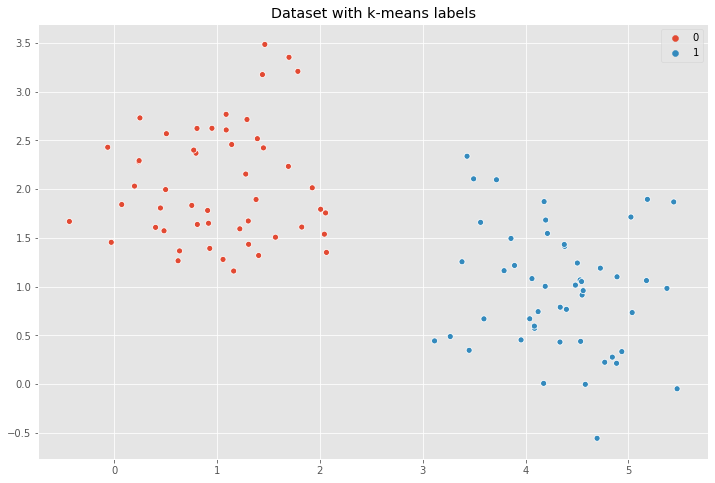

In [ ]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(2, random_state=0)
labels = kmeans.fit(X).predict(X)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels)
plt.title('Dataset with k-means labels');

Let's look at their centers

In [ ]:
kmeans.cluster_centers_

array([[1.0168431 , 2.04544835],
       [4.32924029, 0.96079228]])

It's time for our Pyro GMM model. Get ready...

Study the code below carefully:

In [ ]:
def gmm(data=None, K=2):
    # Prior for the mixing proportions
    weights = pyro.sample("weights", pyro.distributions.Dirichlet(torch.ones(K)))
    
    # Priors for the mixture components
    with pyro.plate('components', K):
        mu = pyro.sample('mu', pyro.distributions.Normal(torch.zeros(2), 5.*torch.ones(2)).to_event(1))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(5.*torch.ones(2)).to_event(1))

    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', pyro.distributions.Categorical(weights), infer={"enumerate": "parallel"})
        points = pyro.sample('obs', pyro.distributions.Normal(mu[assignment], sigma[assignment]).to_event(1), obs=data)

    return points

Notice that since our data points are 2-dimensional, the mean ```mu``` and scale ```sigma``` of each cluster ```k``` must also be 2-dimensional. Therefore, we made use of the ```.to_event(1)``` to make ```mu``` and ```sigma``` be treated by Pyro as multivariate distributions. When in doubt, have a look at the ```batch_shape``` and ```event_shape```:

In [ ]:
d = pyro.distributions.Normal(torch.zeros(2), 5.*torch.ones(2)).to_event(1)
print("shape:", d.shape())
print("batch_shape:", d.batch_shape)
print("event_shape:", d.event_shape)

shape: torch.Size([2])
batch_shape: torch.Size([])
event_shape: torch.Size([2])




Inspect carefully the following code too. Particularly, notice that we're running with a single chain, instead of the default (chains=4, iterations=1000). Why would that be? 

To answer this question, run this code and check the results (compare with the centers above).

In [ ]:
X_torch = torch.from_numpy(X.copy()).float()

# Run inference in Pyro
nuts_kernel = NUTS(gmm)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(X_torch)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [04:41,  5.33it/s, step size=7.02e-01, acc. prob=0.868]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
weights[0]      0.50      0.05      0.50      0.42      0.58   2837.95      1.00
weights[1]      0.50      0.05      0.50      0.42      0.58   2837.95      1.00
   mu[0,0]      4.33      0.08      4.33      4.19      4.47   1585.57      1.00
   mu[0,1]      0.96      0.09      0.96      0.82      1.11   1499.38      1.00
   mu[1,0]      1.02      0.10      1.02      0.86      1.17   1196.84      1.00
   mu[1,1]      2.04      0.09      2.04      1.90      2.17   1383.86      1.00
sigma[0,0]      0.60      0.06      0.59      0.50      0.70   1444.14      1.00
sigma[0,1]      0.64      0.07      0.64      0.52      0.74   1656.09      1.00
sigma[1,0]      0.64      0.07      0.63      0.53      0.75    992.98      1.00
sigma[1,1]      0.61      0.07      0.60      0.50      0.71   1369.86      1.00

Number of divergences: 0


Now, try to put the default values (chains=4, iterations=1000). What's the problem? 


Create and test a new version of the code above with higher K (e.g. K=3). 

### Bonus: Alternative way of doing inference using Stochastic Variational Inference (optional)

**Important:** The following code is rather advanced and is really meant to be a bonus. It shows how to perform another type of approximate Bayesian inference in the ```gmm``` model, namely variational inference (VI). In this particular case, running VI can be a bit tricky and requires the introduction of a new Pyro primitive ```pyro.param```. If this section confuses you, please ignore it entirely. You will learn about VI later in the course, and you will also learn how to run VI in Pyro starting with much simpler examples. We decided to keep this code here for the sake of completeness. Later on you may return to it and get useful insights. 

Briefly, in VI we specify a parametric distribution $q(\textbf{z}|\boldsymbol\phi)$ (called the *variational distribution*) with parameters $\boldsymbol\phi$. The goal is the to find the values of the parameters $\boldsymbol\phi$ that make $q(\textbf{z}|\boldsymbol\phi)$ and close as possible to the true posterior distribution $p(\textbf{z}|\textbf{x})$, thereby turning the problem of Bayesian inference into an optimization problem.

In Pyro, the variational distribution is specified in a ```guide```, just like the model function. In fact, there are classes (e.g. ```AutoDiagonalNormal``` and ```AutoMultivariateNormal```) that generate the guide function automatically: 

```
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
guide = AutoMultivariateNormal(gmm)
```

However, for this particular problem, since there are a lot of constraints on the support of some of the distributions, we need to define the guide function manually:

In [ ]:
from torch.distributions import constraints

def guide(data=None, K=2):
    # Use a conjugate guide for global variables.
    weights_posterior = pyro.param("weights_posterior", 1.*torch.ones(K), constraint=constraints.positive)
    pyro.sample("weights", pyro.distributions.Dirichlet(weights_posterior))
    
    mu_loc = pyro.param("mu_loc", torch.zeros(K,2))
    mu_scale = pyro.param("mu_scale", 1.*torch.ones(K,2), constraint=constraints.positive)
    sigma_scale = pyro.param("sigma_scale", 1.*torch.ones(K,2), constraint=constraints.positive)
    with pyro.plate('components', K):
        mu = pyro.sample('mu', pyro.distributions.Normal(mu_loc, mu_scale).to_event(1))
        sigma = pyro.sample('sigma', pyro.distributions.Normal(sigma_scale, 0.1).to_event(1))

Notice how the structure of the guide function closely follows the one of the model function. In fact, the inputs to the function and names of the distributions and plates must match the ones in the model definition! To specify the learnable parameters of the guide we made use of the ```pyro.param``` primitive.

Once the guide is properly defined, we can run variational inference in Pyro:

In [ ]:
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam, ClippedAdam

# Define the number of optimization steps
n_steps = 3000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = TraceEnum_ELBO(num_particles=1, max_plate_nesting=1)
svi = SVI(gmm, guide, optimizer, loss=elbo)

# Reset parameter values
pyro.clear_param_store()

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 699.5
[100] ELBO: 380.2
[200] ELBO: 350.8
[300] ELBO: 353.5
[400] ELBO: 358.1
[500] ELBO: 352.4
[600] ELBO: 344.8
[700] ELBO: 328.6
[800] ELBO: 284.9
[900] ELBO: 306.7
[1000] ELBO: 299.3
[1100] ELBO: 350.1
[1200] ELBO: 287.9
[1300] ELBO: 310.1
[1400] ELBO: 291.7
[1500] ELBO: 284.6
[1600] ELBO: 283.6
[1700] ELBO: 314.1
[1800] ELBO: 287.3
[1900] ELBO: 307.3
[2000] ELBO: 290.5
[2100] ELBO: 286.8
[2200] ELBO: 288.2
[2300] ELBO: 363.2
[2400] ELBO: 309.7
[2500] ELBO: 287.2
[2600] ELBO: 289.8
[2700] ELBO: 287.2
[2800] ELBO: 317.6
[2900] ELBO: 293.9


Variational inference is typically much faster than MCMC methods (especially when we make use of the GPU and CUDA for the computations, which is not the case). However, as you saw in this quick demo, in some situations, it requires a bit more work to set up. 

Let's have a look at the predictions:

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(gmm, guide=guide, num_samples=1000,
                        return_sites=("mu","sigma", "weights"))
samples = predictive(X_torch)

Note that we now passed the ```guide``` function to the ```Predictive``` class.

In [ ]:
samples["mu"].mean(axis=0)

tensor([[1.0189, 2.0536],
        [4.3010, 0.9683]], grad_fn=<MeanBackward1>)

In [ ]:
samples["weights"].mean(axis=0)

tensor([[0.4587, 0.5413]], grad_fn=<MeanBackward1>)

In [ ]:
samples["sigma"].mean(axis=0)

tensor([[0.6584, 0.5666],
        [0.5877, 0.6114]], grad_fn=<MeanBackward1>)

Quite accurate too, right? :-)